In [29]:
!pip install lime

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, auc
)
from sklearn.utils import resample
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import RocCurveDisplay
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# Data Preprocessing and Feature Engineering

In [31]:
# Download datasets
from google.colab import files
uploaded = files.upload()

Saving bcsc_risk_factors_summarized1_092020.csv to bcsc_risk_factors_summarized1_092020 (1).csv
Saving bcsc_risk_factors_summarized2_092020.csv to bcsc_risk_factors_summarized2_092020 (1).csv
Saving bcsc_risk_factors_summarized3_092020.csv to bcsc_risk_factors_summarized3_092020 (1).csv


In [32]:
df_1 = pd.read_csv('bcsc_risk_factors_summarized1_092020.csv')
df_2 = pd.read_csv('bcsc_risk_factors_summarized2_092020.csv')
df_3 = pd.read_csv('bcsc_risk_factors_summarized3_092020.csv')

In [33]:
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
print(df.shape)

(1522340, 13)


In [34]:
# Drop unused columns "year" and "count"
df = df.drop(columns=['year', 'count'])

# Making data types categorical
df = df.astype('category')

In [35]:
# Replace 9 with NaN in all columns except "age_group_5_years"
cols_except_age = df.columns[df.columns != 'age_group_5_years']
df[cols_except_age] = df[cols_except_age].replace(9, np.nan)

# Drop rows where breast_cancer_history(target) is NaN
df = df.dropna(subset=['breast_cancer_history'])

/tmp/ipython-input-564063165.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[cols_except_age] = df[cols_except_age].replace(9, np.nan)


In [36]:
# Fill NaN in each remaining column with the mode
for col in df.columns:
    if col != 'breast_cancer_history':
        df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-1306297356.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [37]:
# One-hot encoding for 'race_eth'
df = pd.get_dummies(df, columns=['race_eth'], drop_first=True)
df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)

In [38]:
df.head()

age_group_5_years first_degree_hx age_menarche age_first_birth  \
0                 7               0            1               3   
1                 7               0            1               3   
2                 7               0            1               3   
3                 7               0            1               3   
4                 7               0            1               3   

  BIRADS_breast_density current_hrt menopaus bmi_group biophx  \
0                     1           1        2         3      0   
1                     1           1        2         3      1   
2                     1           1        2         4      0   
3                     1           1        2         4      1   
4                     1           1        2         4      1   

  breast_cancer_history  race_eth_2  race_eth_3  race_eth_4  race_eth_5  \
0                     0           0           0           0           0   
1                     0           0           0           0           0   
2                     0           0           0           0           0   
3                     0           0           0           0           0   
4                     1           0           0           0           0   

   race_eth_6  
0           0  
1           0  
2           0  
3           0  
4           0

# Model 1 - SVM for Binary Classification

In [39]:
# Features and target
X_bin = df.drop(columns=['breast_cancer_history'])
y_bin = df['breast_cancer_history']

# Train-test split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

# Scaling
scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)

# LinearSVC with class weights
svm_bin = LinearSVC(class_weight='balanced', max_iter=5000)
svm_bin.fit(X_train_bin_scaled, y_train_bin)

# Decision function for continuous scores
decision_scores_bin = svm_bin.decision_function(X_test_bin_scaled)

# Function to evaluate thresholds
def evaluate_thresholds(decision_scores, y_true, thresholds=np.arange(-1, 1, 0.05)):
    print("Threshold | Recall | Precision | F1")
    for t in thresholds:
        y_pred = (decision_scores >= t).astype(int)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        print(f"{t:>8.2f} | {recall:.3f} | {precision:.3f} | {f1:.3f}")

# Evaluate thresholds
evaluate_thresholds(decision_scores_bin, y_test_bin)

# Choose threshold for high recall
threshold_bin = -0.05
y_pred_bin = (decision_scores_bin >= threshold_bin).astype(int)

# Final Evaluation
print("\nBinary SVM - Final Evaluation (Threshold = {})".format(threshold_bin))
print("Accuracy:", accuracy_score(y_test_bin, y_pred_bin))
print("\nClassification Report:\n", classification_report(y_test_bin, y_pred_bin))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_bin))

Threshold | Recall | Precision | F1
   -1.00 | 0.999 | 0.191 | 0.320
   -0.95 | 0.999 | 0.193 | 0.323
   -0.90 | 0.998 | 0.196 | 0.327
   -0.85 | 0.996 | 0.199 | 0.332
   -0.80 | 0.994 | 0.204 | 0.339
   -0.75 | 0.992 | 0.210 | 0.346
   -0.70 | 0.988 | 0.217 | 0.356
   -0.65 | 0.983 | 0.226 | 0.367
   -0.60 | 0.977 | 0.236 | 0.380
   -0.55 | 0.968 | 0.248 | 0.395
   -0.50 | 0.955 | 0.260 | 0.408
   -0.45 | 0.941 | 0.273 | 0.423
   -0.40 | 0.923 | 0.286 | 0.436
   -0.35 | 0.905 | 0.298 | 0.448
   -0.30 | 0.883 | 0.309 | 0.458
   -0.25 | 0.862 | 0.318 | 0.465
   -0.20 | 0.842 | 0.326 | 0.470
   -0.15 | 0.820 | 0.334 | 0.475
   -0.10 | 0.800 | 0.342 | 0.479
   -0.05 | 0.776 | 0.350 | 0.482
    0.00 | 0.751 | 0.359 | 0.486
    0.05 | 0.724 | 0.368 | 0.488
    0.10 | 0.695 | 0.378 | 0.490
    0.15 | 0.660 | 0.389 | 0.490
    0.20 | 0.622 | 0.402 | 0.488
    0.25 | 0.578 | 0.416 | 0.484
    0.30 | 0.527 | 0.429 | 0.473
    0.35 | 0.475 | 0.443 | 0.459
    0.40 | 0.412 | 0.457 | 0.433
    0.4

Binary SVM ROC-AUC: 0.7926841741872438


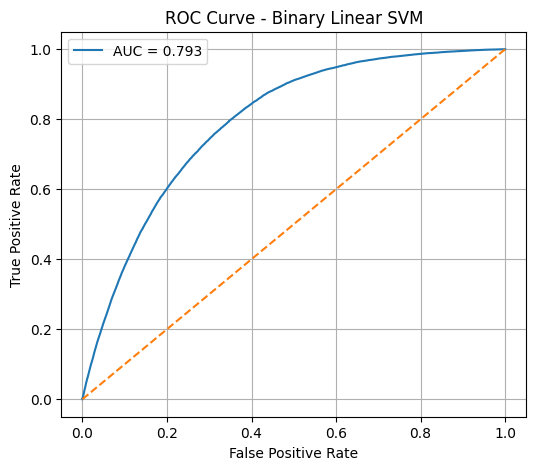

In [40]:
# ROC-AUC
roc_auc_bin = roc_auc_score(y_test_bin, decision_scores_bin)
print("Binary SVM ROC-AUC:", roc_auc_bin)

# ROC Curve
fpr_bin, tpr_bin, _ = roc_curve(y_test_bin, decision_scores_bin)
plt.figure(figsize=(6,5))
plt.plot(fpr_bin, tpr_bin, label=f"AUC = {roc_auc_bin:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Binary Linear SVM")
plt.legend()
plt.grid(True)
plt.show()

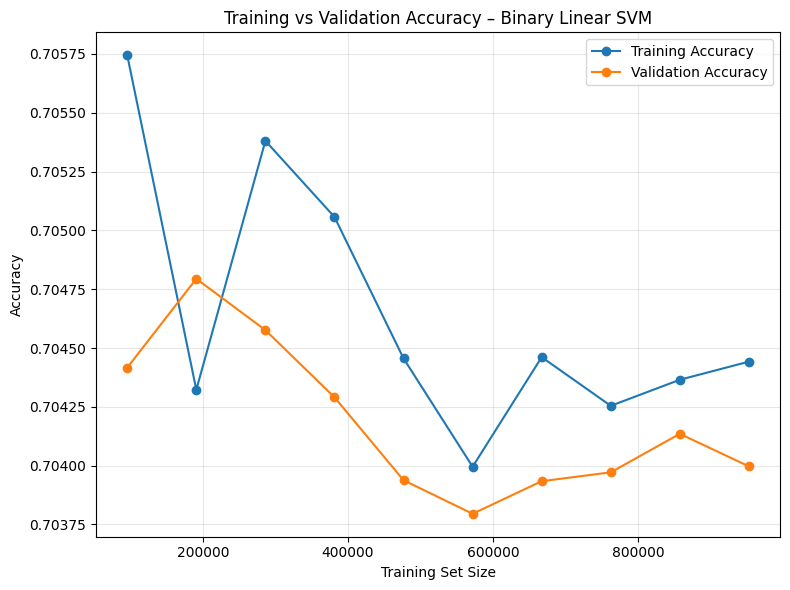

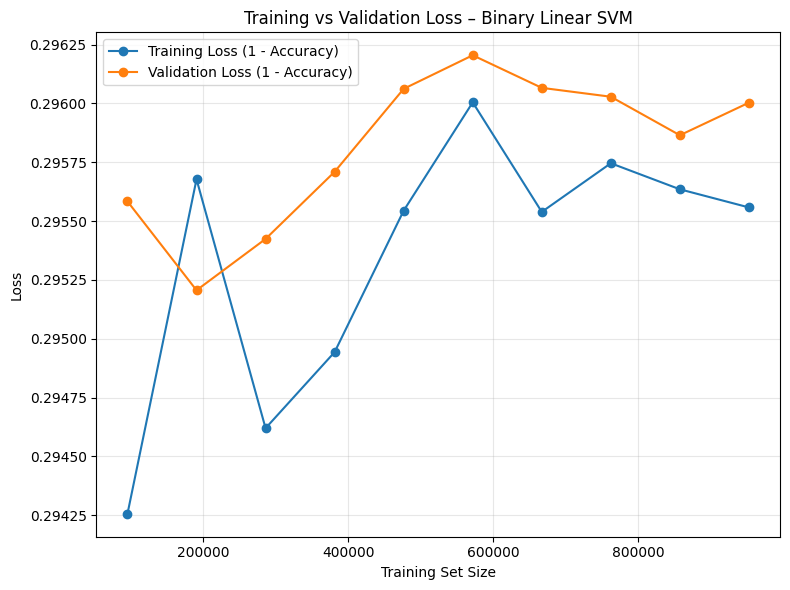

In [41]:
# Fractions of training data
fractions = np.linspace(0.1, 1.0, 10)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train_sizes = (fractions * len(X_train_bin_scaled)).astype(int)

for n in train_sizes:
    svm_partial = LinearSVC(class_weight='balanced', max_iter=5000)
    svm_partial.fit(X_train_bin_scaled[:n], y_train_bin[:n])

    y_train_pred = svm_partial.predict(X_train_bin_scaled[:n])
    y_val_pred = svm_partial.predict(X_test_bin_scaled)

    train_acc = accuracy_score(y_train_bin[:n], y_train_pred)
    val_acc = accuracy_score(y_test_bin, y_val_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    train_losses.append(1 - train_acc)
    val_losses.append(1 - val_acc)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(train_sizes, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy – Binary Linear SVM')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Training vs Validation Loss
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_losses, marker='o', label='Training Loss (1 - Accuracy)')
plt.plot(train_sizes, val_losses, marker='o', label='Validation Loss (1 - Accuracy)')
plt.xlabel('Training Set Size')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss – Binary Linear SVM')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Model 2 - SVM For Multi-class Classification



In [42]:
from sklearn.linear_model import LogisticRegression

# Features and target
X = df.drop(columns=['breast_cancer_history'])
y = df['breast_cancer_history']

# Logistic regression
model = LogisticRegression(max_iter=5000)
model.fit(X, y)

# Predicted cancer probability
df['pred_prob'] = model.predict_proba(X)[:, 1]
df['breast_cancer_history_3class'] = df['breast_cancer_history'].copy()
df['breast_cancer_history_3class'] = df['breast_cancer_history_3class'].cat.add_categories([2])

# Thresholds for borderline high-risk class
lower_thresh = 0.35
upper_thresh = 0.50

# New class labeling
borderline_mask = (
    (df['breast_cancer_history'] == 0) &
    (df['pred_prob'] >= lower_thresh) &
    (df['pred_prob'] <= upper_thresh)
)

df.loc[borderline_mask, 'breast_cancer_history_3class'] = 2

print(df['breast_cancer_history_3class'].value_counts())
print(df['breast_cancer_history_3class'].dtype)
# 0 = healthy, 1 = cancer, 2 = borderline

breast_cancer_history_3class
0    888887
1    221776
2     80775
Name: count, dtype: int64
category


In [43]:
df = df.drop(["breast_cancer_history", "pred_prob"], axis=1)

In [44]:
# Features and target
X_multi = df.drop(columns=['breast_cancer_history_3class'])
y_multi = df['breast_cancer_history_3class']

# Train-test split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# Scaling
scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)

# LinearSVC for multiclass
svm_multi = LinearSVC(class_weight='balanced', max_iter=5000)
svm_multi.fit(X_train_multi_scaled, y_train_multi)

# Decision function
decision_scores_multi = svm_multi.decision_function(X_test_multi_scaled)

# Predict classes
y_pred_multi = decision_scores_multi.argmax(axis=1)

# Evaluation
print("\nMulticlass SVM - Evaluation")
print("Train Accuracy:", accuracy_score(y_train_multi, svm_multi.decision_function(X_train_multi_scaled).argmax(axis=1)))
print("Test Accuracy:", accuracy_score(y_test_multi, y_pred_multi))
print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_multi, y_pred_multi))


Multiclass SVM - Evaluation
Train Accuracy: 0.7249404605780831
Test Accuracy: 0.7258653394212046

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88    177778
           1       0.34      0.19      0.24     44355
           2       0.27      0.75      0.40     16155

    accuracy                           0.73    238288
   macro avg       0.50      0.60      0.51    238288
weighted avg       0.75      0.73      0.73    238288


Confusion Matrix:
 [[152521  11976  13281]
 [ 16635   8310  19410]
 [     0   4021  12134]]


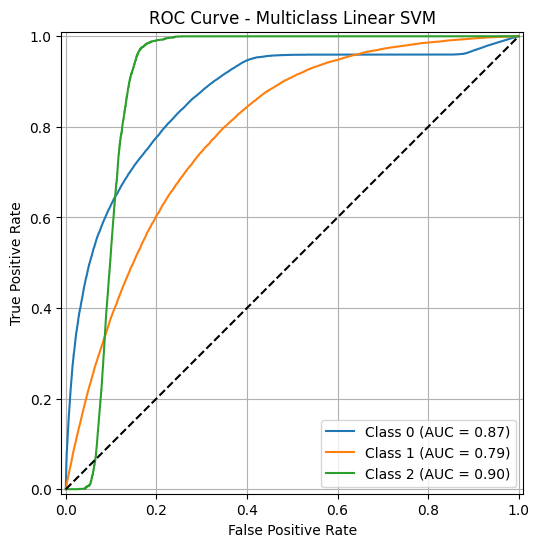

In [45]:
# One-vs-Rest ROC Curve
y_test_bin_multi = label_binarize(y_test_multi, classes=[0,1,2])

plt.figure(figsize=(7,6))
class_names = ["Class 0", "Class 1", "Class 2"]

for i in range(3):
    RocCurveDisplay.from_predictions(
        y_test_bin_multi[:, i],
        decision_scores_multi[:, i],
        name=class_names[i],
        ax=plt.gca()
    )

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multiclass Linear SVM")
plt.grid(True)
plt.legend()
plt.show()

# Downsampling for the 3-Class Classification Task

In [46]:
# Features and target
X = df.drop(columns=['breast_cancer_history_3class'])
y = df['breast_cancer_history_3class']

df_combined = X.copy()
df_combined['target'] = y

# Separate majority and minority classes
df_majority = df_combined[df_combined['target'] == 0]
df_minority1 = df_combined[df_combined['target'] == 1]
df_minority2 = df_combined[df_combined['target'] == 2]

# Downsample majority class to match roughly minority class
n_samples = len(df_minority1) + len(df_minority2)
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=n_samples,
    random_state=42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority1, df_minority2])

# Split features and target
X_balanced = df_balanced.drop(columns=['target'])
y_balanced = df_balanced['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LinearSVC with balanced class weights
svm_downsampled = LinearSVC(class_weight='balanced', max_iter=8000)
svm_downsampled.fit(X_train_scaled, y_train)

# Prediction
decision_scores = svm_downsampled.decision_function(X_test_scaled)
y_pred = decision_scores.argmax(axis=1)

# Evaluation
print("\nMulticlass SVM - Downsampling Majority Class")
print("Train Accuracy:", accuracy_score(y_train, svm_downsampled.predict(X_train_scaled)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Multiclass SVM - Downsampling Majority Class
Train Accuracy: 0.6192414079461909
Test Accuracy: 0.6181076011601292

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     60511
           1       0.52      0.45      0.48     44355
           2       0.31      0.40      0.35     16155

    accuracy                           0.62    121021
   macro avg       0.54      0.55      0.54    121021
weighted avg       0.62      0.62      0.62    121021


Confusion Matrix:
 [[48309  9023  3179]
 [13268 20054 11033]
 [    0  9714  6441]]


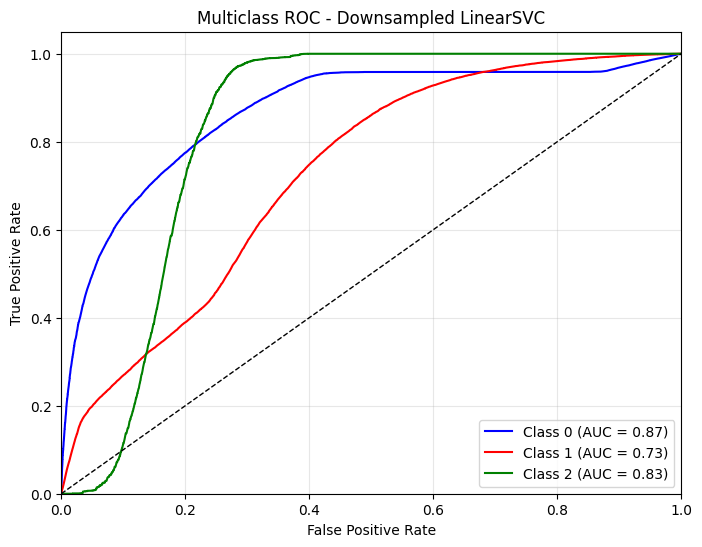

In [47]:
# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test_bin.shape[1]

# Decision_function returns (n_samples, n_classes) scores
y_score = decision_scores

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8,6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC - Downsampled LinearSVC')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


# Adding Explainability Using LIME



In [48]:
# Build LIME Explainer
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train_bin_scaled),
    feature_names=list(X_bin.columns),
    class_names=['Healthy', 'Cancer'],
    mode='classification'
)

# decision_function -> pseudo-probabilities
# LinearSVC returns only decision_function values svm_predict_proba converts them to softmax-like 2-class 'probabilities'
def svm_predict_proba(X):

    scores = svm_bin.decision_function(X)

    # reshape for binary classification
    if scores.ndim == 1:
        scores = scores.reshape(-1, 1)

    # convert to 2-class probabilities using logistic function
    probs_pos = 1 / (1 + np.exp(-scores))
    probs_neg = 1 - probs_pos

    return np.hstack([probs_neg, probs_pos])

# Choose test sample
i = 10
instance = X_test_bin_scaled[i]

# Generate LIME Explanation
exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=svm_predict_proba,
    num_features=10
)

exp.show_in_notebook(show_table=True)

In [49]:
def svm_multi_proba(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)

    df = svm_multi.decision_function(x)
    exp_df = np.exp(df - np.max(df, axis=1, keepdims=True))
    probs = exp_df / np.sum(exp_df, axis=1, keepdims=True)

    return probs

In [50]:
# LIME for 3-class
explainer_multi = LimeTabularExplainer(
    training_data = X_train_multi_scaled,
    feature_names = X_multi.columns,
    class_names = ['Healthy', 'Cancer', 'Maybe'],
    mode='classification'
)

In [51]:
i = 10  # example index
x = X_test_multi_scaled[i]

exp_multi = explainer_multi.explain_instance(
    data_row=x,
    predict_fn=svm_multi_proba,
    top_labels=3,
    num_features=10
)

exp_multi.show_in_notebook(show_table=True)

In [52]:
# LIME explainer for downsampled case
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X_train.columns,
    class_names=['Healthy', 'Cancer', 'Maybe'],
    mode='classification'
)

i = 10
instance = X_test_scaled[i]

def svm_predict_proba(X):
    from scipy.special import softmax
    return softmax(svm_downsampled.decision_function(X), axis=1)

exp = explainer.explain_instance(instance, svm_predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

/tmp/ipython-input-2303899566.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1055896427250882' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  feature_contributions.loc[feature_name, 'Importance'] += abs(weight)


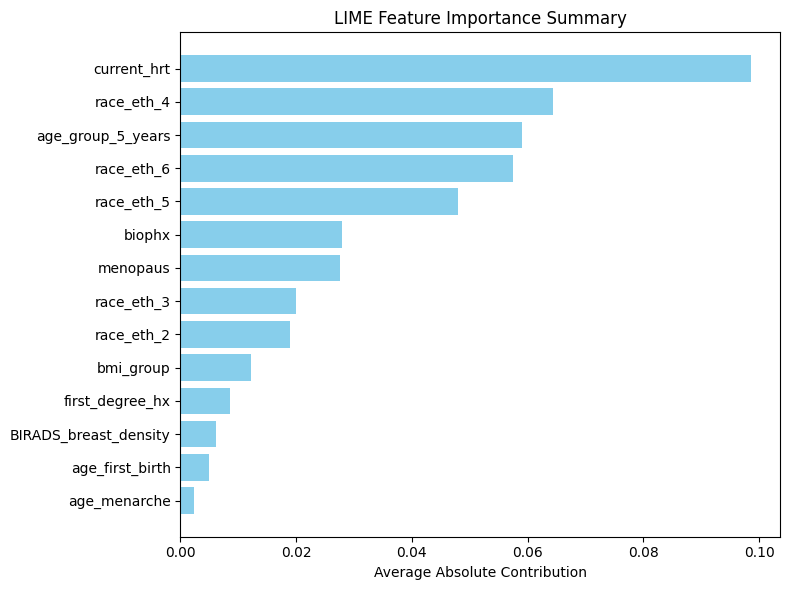

In [53]:
# Store LIME feature contributions for multiple test instances
feature_contributions = pd.DataFrame(0, index=X_test.columns, columns=['Importance'])

# Explain first N test instances
N = 50
for i in range(N):
    instance = X_test_scaled[i]
    exp = explainer.explain_instance(instance, svm_predict_proba, num_features=X_train.shape[1])
    for feature, weight in exp.as_list():
        feature_name = feature.split(' ')[0]
        if feature_name in feature_contributions.index:
            feature_contributions.loc[feature_name, 'Importance'] += abs(weight)

# Average importance over N instances
feature_contributions['Importance'] /= N

# Sort by importance
feature_contributions = feature_contributions.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8,6))
plt.barh(feature_contributions.index, feature_contributions['Importance'], color='skyblue')
plt.title(f'LIME Feature Importance Summary')
plt.xlabel('Average Absolute Contribution')
plt.tight_layout()
plt.show()